# Neural Network from scratch - Implementation

If you want to have a basic knowledge of neural network, I strongly encourage you to read [A Basic Introduction To Neural Networks](http://pages.cs.wisc.edu/~bolo/shipyard/neural/local.html).

## Import packages

In [32]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets as dataset
import sklearn.linear_model
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (10, 8)

## Generate a dataset

First of all, I'll use a dataset generator called [`make_moons`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) from scikit learn.

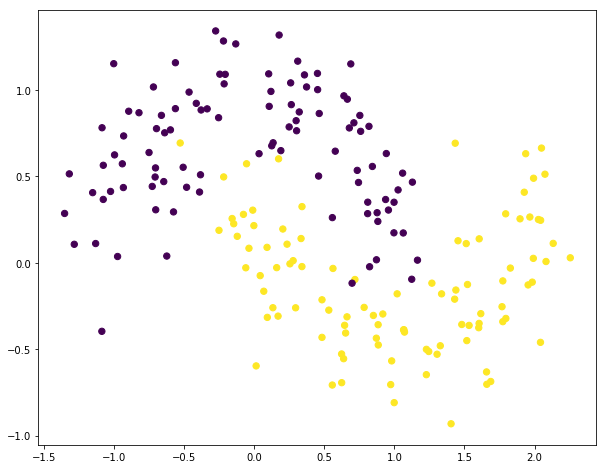

In [33]:
np.random.seed(0)  # makes random numbers predictable 
x, y = dataset.make_moons(200, noise = 0.2)
plt.scatter(x[:, 0], x[:, 1], c = y, s = 40)

This dataset has 2 classes: black dots = dog, yellow dots = cat, with the x- and y- axises being appearance measurements.

Since the data cannot be linearly separable, those linear classifiers, such as linear regression, won't be able to fit in it. 

Here is what Neural Network is useful for.

In [34]:
# Helper function to help building a decision boundary
def plot_decision_boundary(func):
    h = .01  # step size in the mesh
    # Plot decision regions
    x_min, x_max = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
    y_min, y_max = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Point in the mesh [x_min, x_max]X[y_min, y_max]
    z = func(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    
    # Put the result into a color plot
    plt.contour(xx, yy, z, cmap=plt.cm.Spectral)
    plt.scatter(x[:, 0], x[:, 1], c = y)

## Train the Neural Network

I am going to buld a 3-layer neural network which contains 1 input, 1 hidden and 1 output layer. The number of nodes of the input layer is determined by the dimensionality of the dataset, which is 2; the number of nodes of the output layer is determined by the number of classes, which is also 2. The input to the network will be x- and y- coordinates, and its output will be two probabilities: class 0 = "Dog", class 1 = "Cat", here is the figure:

<img src='./dog-cat-network.png' style='width: 70%'/>

We can choose the number of nodes of the hidden layer. The more nodes in the hidden layer, the more complex function it will be able to fit, and the higher cost it will result in. Moreover, higher dimensionality may also be prone to overfitting the data.

The how should we choose the size of the hidden layer? There is no specific answer, and it always depends on the problem you have. Later on I will play with the number of node sand see how it will affect the output.

## Choose Activation Function

Activation function transforms the inputs of a layer into its outputs. Here I am not going to use linear function since my data does not fit in linear hypotheses. Three common nonlinear activation functions in Neural Network are sigmoid function, tanh, and ReLUs; if you want more detailed comparison among these three functions, I recommand to read [Understanding Activation Functions in Neural Networks](https://medium.com/the-theory-of-everything/understanding-activation-functions-in-neural-networks-9491262884e0).

I will use`tanh`. Here is a figure to show how a tanh function looks like:
<img src='./tanh-graph.png' style='width: 50%' />

The main advantage is that the negative inputs will be mapped strongly negative and the zero inputs will be mapped near zero in `tanh` graph. Furthermore, `tanh` is mainly used classification between two classes.

## Gradient Computation

### Implement Forward Propagation

Neural Network performs *forward propagation* to compute $a_i$ for $i$ = 2, 3, ... , L. Here is a simple network for my data:
<img src='./forward-prop.png' style='width: 40%' />

Let's see how forward propagation computes for my 3-layer neural network. Given one training example ($x$, $y$):

$$
\begin{aligned}
a_1 & = x \\
z_2 & = \theta_1a_1 + b_1 \\
a_2 & = \tanh(z_2) \\
z_3 & = \theta_2a_2 + b_2\\
a_3 & = h_\theta(x) = \mathrm{softmax}(z_3) \approx y
\end{aligned}
$$

$z_i$ is the weighted sum of inputs of layer $i$. 

$a_1$ is assigned to be the training input $x$, and $a_i$ for $i$=2,3,...,L is the output of layer $i$ after applying the activation function.

$\theta_1, \theta_2$ are weight parameters of the network, and $b_1, b_2$ are biases. They need to learn from the training dataset. Here is an example figure of weight and bias: <img src='./weight-bias.png' style='width: 25%' />

At the last output layer, I will use [`softmax function`](https://en.wikipedia.org/wiki/Softmax_function) to convert raw scores into probabilities. The main advantage of using softmax is if it used for multi-classification, it returns the probabilities of each class and the target class will have the high probability.

Let me implement `softmax` as a helper function:

In [35]:
def softmax(inputs):
    return np.exp(inputs) / np.sum(np.exp(inputs), axis=1, keepdims=True)

## Implement Cost Function

Learning the parameters for the network means finding $\theta_i$ for $i$=1,2,...L-1 that minimize the error on the training set. To define the error, we implement the *cost function*. A common choice with softmax output is [`Cross-entropy cost function`](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression). If there are $N$ training examples and $k$ classes then the cost for the predictions $h_\theta(x_n)$ for $n$=1,2,...,N with respect to the true outputs $y_n$ for $n$=1,2,...,N is given by:

$$
\begin{aligned}
C(y, h_\theta(x)) = -\frac{1}{N} \sum_{n \in N} \sum_{i \in k} y_{n,i} \log h_\theta(x_{n})_{i}
\end{aligned}
$$

This may look complicated, but all it does is summing the training set and adding to the cost if we predict any error.

## Implement backpropagation to Compute Partial Derivatives

`Backpropagation` is neural-network terminology for minimizing the cost function, just like doing gradient descent in logistic and linear regression. In other words, we want to minimize the cost function $C$ using an optimal set of parameters in $\theta$. Next we are going to look at the equations used to compute the partial derivatives of $C$: 

Given a training set {($x_1, y_1$),.., ($x_m, y_m$)}

Set $\Delta_1$ = $\Delta_2$ = 0, hence it will end up having a matrix full of zeros

For $i$ = 1 to $m$:

$$
\begin{aligned}
& \delta_3 = h_\theta(x) - y \\
& \delta_2 = (1 - \tanh^2z_2) \circ \theta_2^T\delta_3 \\
& \Delta_2 := \Delta_2 + \delta_3a_2^T \\
& \Delta_1 := \Delta_1 + \delta_2a_1^T \\
\end{aligned}
$$

After iterating through all of the training examples:

$$
\begin{aligned}
& \frac{\partial{C}}{\partial{\theta_2}} = \frac{1}{m} \Delta_2 + \lambda\theta_2 \\
& \frac{\partial{C}}{\partial{b_2}} = \delta_3 \\
& \frac{\partial{C}}{\partial{\theta_1}} = \frac{1}{m} \Delta_1 + \lambda\theta_1 \\
& \frac{\partial{C}}{\partial{b_1}} = \delta_2 \\
\end{aligned}
$$

## Use Gradient Descent

Next thing I am going to do is to use `gradient descent` to minimize the cost function with the weights in $\theta_1$ and $\theta_2$ and biases in $b_1$ and $b_2$. Ideally, we want $h_\theta(x_i) \approx y_i$. This will minimize the cost function. However, keep in mind that the cost function $C$ is not convex and thus we can end up in a local mininmum instead of a global minimum.

## Implementation

I start my implementation by defining some variables and parameters for gradient descent.

In [36]:
set_size = len(x)  # size of the training set
input_dim = 2      # dimension of the input layer
output_dim = 2     # dimension of the output layer

# Gradient descent parameters 
epsilon = 0.01     # learning rate for gradient descent
reg_lambda = 0.01      # regularization strength

**Now let's implement the cost function.**

In [37]:
def cost_function(model):
    w1, w2, b1, b2 = model['w1'], model['w2'], model['b1'], model['b2']
    
    # Forwward propagation
    z2 = x.dot(w1) + b1
    a2 = np.tanh(z2)
    z3 = a2.dot(w2) + b2
    probs = softmax(z2)
    
    # Calculate the cost
    logProbs = -np.log(probs[range(set_size), y])
    data_cost = np.sum(logProbs)
    
    # Add regularization term to cost
    data_cost += reg_lambda / 2 * (np.sum(np.square(w1)) + np.sum(np.square(w2)))
    
    return 1./set_size * data_cost

In [38]:
# Helper function to perdict an output
def predict(model, x):
    w1, w2, b1, b2 = model['w1'], model['w2'], model['b1'], model['b2']
    # Forwward propagation
    z2 = x.dot(w1) + b1
    a2 = np.tanh(z2)
    z3 = a2.dot(w2) + b2
    probs = softmax(z2)
    return np.argmax(probs, axis = 1)

Finally, let's build the model to train our Neural Network. I will implement backpropagation and use gradient descent as I mentioned above.

In [39]:
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(input_dim, nn_hdim) / np.sqrt(input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = x.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(set_size), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(x.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'w1': W1, 'b1': b1, 'w2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

In [11]:
# hidden_dim: Number of nodes in the hidden layer
# passes_num: Number of passes through the training set for gradient descent
def build_nn(hidden_dim, passes_num=20000):
    # Random initialization: initialilze the weights and biases to random values
    np.random.seed(0)
    w1 = np.random.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
    w2 = np.random.randn(hidden_dim, output_dim) / np.sqrt(hidden_dim)
    b1 = np.zeros((1, hidden_dim))
    b2 = np.zeros((1, output_dim))
    
    model = {}
    
    # Gradient descent
    for i in range(0, passes_num):
        # Forward propagation
        z2 = x.dot(w1) + b1
        a2 = np.tanh(z2)
        z3 = a2.dot(w2) + b2
        probs = softmax(z2)
        
        # Backpropagation
        delta_3 = probs
        delta_3[range(set_size), y] -= 1
        dw2 = (a2.T).dot(delta_3)
        db2 = np.sum(delta_3, axis=0, keepdims=True)
        delta_2 = delta_3.dot(w2.T) * (1 - np.power(a2, 2))
        dw1 = np.dot(x.T, delta_2)
        db1 = np.sum(delta_2, axis=0)
        
        dw2 += reg_lambda * w2
        dw1 += reg_lambda * w1
        
        # Gradient descent parameters update
        w1 += -epsilon * dw1
        w2 += -epsilon * dw2
        b1 += -epsilon * db1
        b2 += -epsilon * db2
        
        # Assign weight and bias parameters to the model
        model = {'w1': w1, 'w2': w2, 'b1': b1, 'b2': b2}
        
    return model

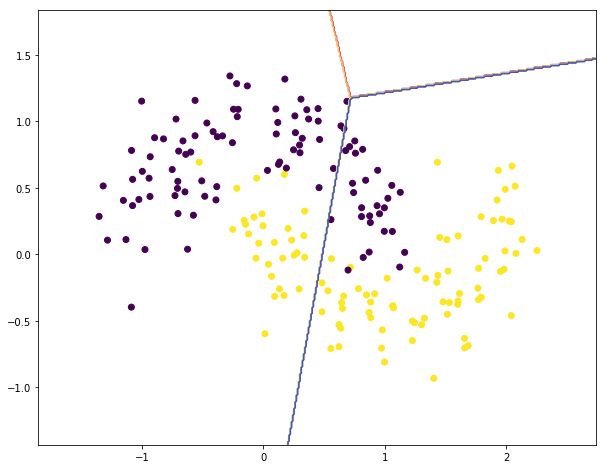

In [40]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))